In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
import os
import copy

HOME = '.'

# Visualize train data distribution for synthetic case

torch.Size([3, 2400000])
torch.Size([3, 2400000])


Text(0, 0.5, 'Occurrency')

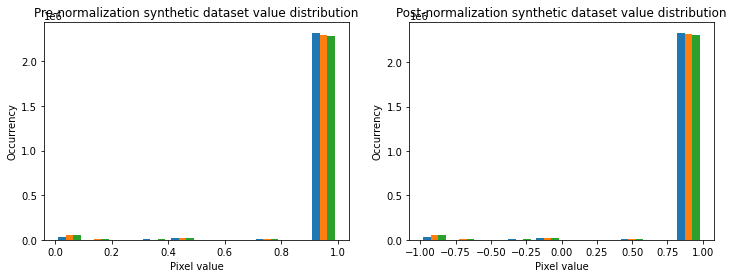

In [2]:
def flatten_channels(img_folder, batch_size=200):
    dataloader = DataLoader(img_folder, batch_size=batch_size, shuffle=True)
    dataiter = iter(dataloader)
    flat_channels = torch.empty((3, 0))
    data = next(dataiter)
    X, _ = data
    transpose = torch.transpose(X, 0, 1)
    flat = torch.flatten(transpose, 1)
    flat_channels = torch.cat((flat_channels, flat), 1)
    return flat_channels

# LOAD TRAIN DATA FOLDER (no norm)
SYNTH_DATA_DIR = os.path.join(HOME, 'training_sample/synthetic')
MEAN = np.array([.5, .5 , .5])
STD = np.array([.5, .5, .5])
nonorm_transform = transforms.ToTensor()
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 2)

# INSPECT PRE-NORMALIZATION DATASET DISTRIBUTION
nonorm_train_data = ImageFolder(SYNTH_DATA_DIR, transform=nonorm_transform)
nonorm_flat_channels = flatten_channels(nonorm_train_data, batch_size=200)

print(nonorm_flat_channels.shape)

ax = axes[0]
ax.hist(torch.transpose(nonorm_flat_channels, 0, 1).numpy())
ax.set_title('Pre-normalization synthetic dataset value distribution')
ax.set_xlabel('Pixel value')
ax.set_ylabel('Occurrency')

# INSPECT POST-NORMALIZATION DATASET DISTRIBUTION
norm_train_data = ImageFolder(SYNTH_DATA_DIR, transform=norm_transform)
norm_flat_channels = flatten_channels(norm_train_data, batch_size=200)

print(norm_flat_channels.shape)

ax = axes[1]
ax.hist(torch.transpose(norm_flat_channels, 0, 1).numpy())
ax.set_title('Post-normalization synthetic dataset value distribution')
ax.set_xlabel('Pixel value')
ax.set_ylabel('Occurrency')

torch.Size([3, 1788020])
torch.Size([3, 1788020])


Text(0, 0.5, 'Occurrency')

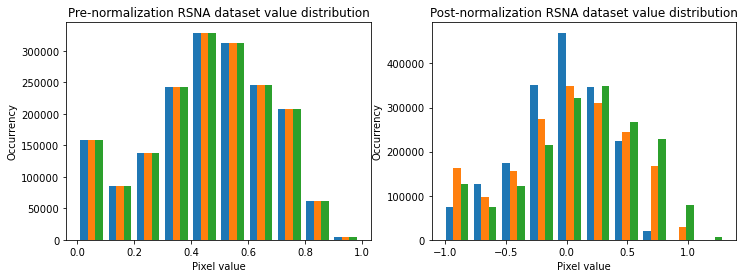

In [3]:
DATA_DIR = os.path.join(HOME, 'training_sample/RSNA')
MEAN = [0.485, 0.456, 0.406]
STD = [0.299, 0.224, 0.225]
nonorm_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor()
])
norm_transform = transforms.Compose([
    nonorm_transform,
    transforms.Normalize(mean=MEAN, std=STD)
])

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 2)

# INSPECT PRE-NORMALIZATION DATASET DISTRIBUTION
nonorm_train_data = ImageFolder(DATA_DIR, transform=nonorm_transform)
nonorm_flat_channels = flatten_channels(nonorm_train_data, batch_size=20)

print(nonorm_flat_channels.shape)

ax = axes[0]
ax.hist(torch.transpose(nonorm_flat_channels, 0, 1).numpy())
ax.set_title('Pre-normalization RSNA dataset value distribution')
ax.set_xlabel('Pixel value')
ax.set_ylabel('Occurrency')

# INSPECT POST-NORMALIZATION DATASET DISTRIBUTION
norm_train_data = ImageFolder(DATA_DIR, transform=norm_transform)
norm_flat_channels = flatten_channels(norm_train_data, batch_size=20)

print(norm_flat_channels.shape)

ax = axes[1]
ax.hist(torch.transpose(norm_flat_channels/2, 0, 1).numpy())
ax.set_title('Post-normalization RSNA dataset value distribution')
ax.set_xlabel('Pixel value')
ax.set_ylabel('Occurrency')

cpu
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Initialized explainer with map size (299, 299)
Initialized explainer with map size (299, 299)
Initialized explainer with map size (299, 299)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False

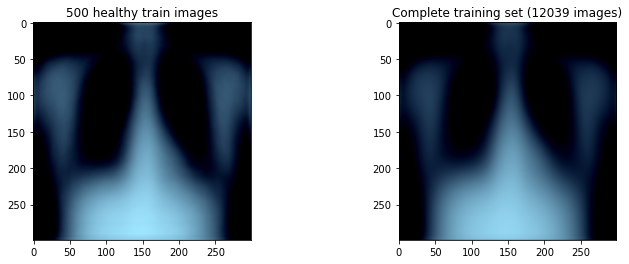

In [10]:
import HShap as HShap

model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net_path = os.path.join(HOME, "RSNA_InceptionV3.pth")
model.load_state_dict(torch.load(net_path, map_location=device))
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.299, 0.224, 0.225]),
])

RSNA_EXAMPLE_DIR = os.path.join(HOME, "RSNA_example_images")
EXPLANATION_DIR = os.path.join(HOME, "explanations/RSNA")
testset = datasets.ImageFolder(RSNA_EXAMPLE_DIR, preprocess)
testnames = testset.imgs
batch_size = 4
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=4
)
dataiter = iter(testloader)

zero_background = torch.tensor(np.zeros((3, 299, 299), dtype=np.uint8))
healthy_avg_background = np.load("avg_500_healthy.npy")
healthy_avg_background = torch.from_numpy(healthy_avg_background)
all_avg_background = np.load("avg_all_train.npy")
all_avg_background = torch.from_numpy(all_avg_background)
hexp = HShap.Explainer(model, zero_background, M=4)
hexp_avg_background = HShap.Explainer(model, healthy_avg_background, M=4)
hexp_renorm = HShap.Explainer(model, zero_background, M=4)
fig = plt.figure(figsize=(12, 4))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(np.transpose(healthy_avg_background, (1, 2, 0)))
ax1.set_title("500 healthy train images")
ax2.imshow(np.transpose(all_avg_background, (1, 2, 0)))
ax2.set_title("Complete training set (12039 images)")


In [5]:
threshold = -np.Infinity
size = 20

data = next(dataiter)
images, labels = data
image = images[0]
hexp_saliency, _ = hexp.explain(image, label=1, threshold=threshold, minW=size, minH=size)
image_renorm = image/2
hexp_saliency_avg_background, _ = hexp_avg_background.explain(image, label=1, threshold=threshold, minW=size, minH=size)
hexp_saliency_avg_background_renorm, _ = hexp.explain(image_renorm, label=1, threshold=threshold, minW=size, minH=size)

Root input [0, 299] [0 299] with score 1.0000
Root input [0, 149] [0 149] with score 2.2561
Root input [0, 74] [0 74] with score -0.5452
Root input [0, 37] [0 37] with score -0.4054
Root input [0, 37] [37 74] with score -0.1015
Root input [37, 74] [0 37] with score -0.1267
Root input [37, 74] [37 74] with score -1.4611
Root input [0, 74] [74 149] with score 2.4573
Root input [0, 37] [74 112] with score 0.3840
Root input [0, 37] [112 149] with score 0.6107
Root input [37, 74] [74 112] with score 1.7159
Root input [37, 74] [112 149] with score 0.9029
Root input [74, 149] [0 74] with score 0.1001
Root input [74, 112] [0 37] with score 0.2065
Root input [74, 112] [37 74] with score 0.3392
Root input [112, 149] [0 37] with score 0.0000
Root input [112, 149] [37 74] with score 0.0000
Root input [74, 149] [74 149] with score 0.0463
Root input [74, 112] [74 112] with score 0.7797
Root input [74, 112] [112 149] with score 0.0000
Root input [112, 149] [74 112] with score 0.0000
Root input [112, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


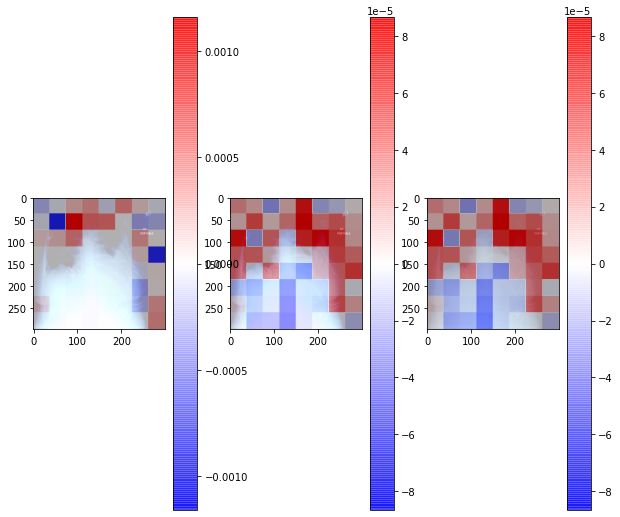

In [6]:
def imshow(ax, pic):
    npimg = np.array(pic)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

fig = plt.figure(figsize=(10, 10))
ax1, ax2, ax3 = fig.subplots(1, 3)
imshow(ax2, image)
imshow(ax3, image_renorm)

# ZERO-BACKGROUND 
imshow(ax1, image)
abs = np.abs(hexp_saliency.flatten())
max = np.nanpercentile(abs, 99.9)
im = ax1.imshow(hexp_saliency, cmap='bwr', alpha=0.7, vmax=max, vmin=-max)
plt.colorbar(im, ax=ax1)

# AVG-BACKGROUND
abs_avg_background = np.abs(hexp_saliency_avg_background.flatten())
max_avg_background = np.nanpercentile(abs_avg_background, 99.9)
im_avg_background = ax2.imshow(hexp_saliency_avg_background, cmap='bwr', alpha=0.7, vmax=max_avg_background, vmin=-max_avg_background)
plt.colorbar(im_avg_background, ax=ax2)

# AVG-BACKGROUND RENORM
abs_avg_background_renorm = np.abs(hexp_saliency_avg_background_renorm.flatten())
max_avg_background_renorm = np.nanpercentile(abs_avg_background_renorm, 99.9)
im_avg_background_renorm = ax3.imshow(hexp_saliency_avg_background, cmap='bwr', alpha=0.7, vmax=max_avg_background, vmin=-max_avg_background)
plt.colorbar(im_avg_background_renorm, ax=ax3)

In [7]:
threshold = -np.Infinity
size = 20

data = next(dataiter)
images, labels = data
for ex_id, image in enumerate(images):
    img_name = testnames[ex_id][0]
    patient_id = os.path.basename(img_name).replace(".png", "")
    hexp_saliency, flatnodes = hexp.explain(image, label=1, threshold=threshold, minW=size, minH=size)
    image_renorm = image/2
    hexp_saliency_renorm, flatnodes_renorm = hexp_renorm.explain(image_renorm, label=1, threshold=threshold, minW=size, minH=size)

with score 0.0000
Root input [74, 112] [37 74] with score 0.0000
Root input [112, 149] [0 37] with score 0.0000
Root input [112, 149] [37 74] with score 0.0000
Root input [74, 149] [74 149] with score 0.0000
Root input [74, 112] [74 112] with score 0.0000
Root input [74, 112] [112 149] with score 0.0000
Root input [112, 149] [74 112] with score 0.0000
Root input [112, 149] [112 149] with score 0.0000
Root input [0, 149] [149 299] with score 1.0670
Root input [0, 74] [149 224] with score 0.6039
Root input [0, 37] [149 186] with score 0.0000
Root input [0, 37] [186 224] with score 0.5031
Root input [37, 74] [149 186] with score 0.0000
Root input [37, 74] [186 224] with score 0.0000
Root input [0, 74] [224 299] with score 0.7992
Root input [0, 37] [224 261] with score 0.7420
Root input [0, 37] [261 299] with score 0.1277
Root input [37, 74] [224 261] with score 0.0000
Root input [37, 74] [261 299] with score 0.2001
Root input [74, 149] [149 224] with score 0.0000
Root input [74, 112] [149

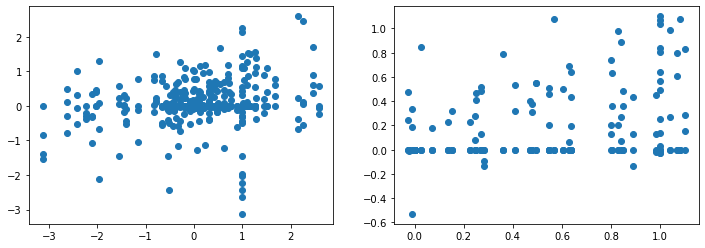

In [8]:
fig = plt.figure(figsize=(12, 4))
ax1, ax2 = fig.subplots(1, 2)
points = hexp.points.reshape((-1, 2))
parent_SHAP = points[:, 0]
child_SHAP = points[:, 1]
ax1.scatter(parent_SHAP, child_SHAP)

points_renorm = hexp_renorm.points.reshape((-1, 2))
parent_SHAP_renorm = points_renorm[:, 0]
child_SHAP_renorm = points_renorm[:, 1]
ax2.scatter(parent_SHAP_renorm, child_SHAP_renorm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([ 0.1826433 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.3652866 ,
         0.        ,  0.1826433 ,  0.        ,  0.        ,  0.        ,
         0.1826433 ,  0.5479299 , 47.30461457,  0.        ,  0.1826433 ,
         0.        ,  0.3652866 ,  0.1826433 ,  0.        ,  0.        ,
         0.9132165 ,  0.1826433 ,  0.        ,  0.3652866 ,  0.7305732 ,
         0.        ,  0.3652866 ,  0.3652866 ,  0.1826433 ,  0.5479299 ,
         0.        ,  0.5479299 ,  0.1826433 ,  0.        ,  0.3652866 ,
         0.1826433 ,  0.        ,  0.3652866 ,  0.        ,  0.3652866 ,
         0.3652866 ,  0.3652866 ,  0.5479299 ,  0.3652866 ,  0.1826433 ,
         0.1826433 ,  0.3652866 ,  0.1826433 ,  0. 

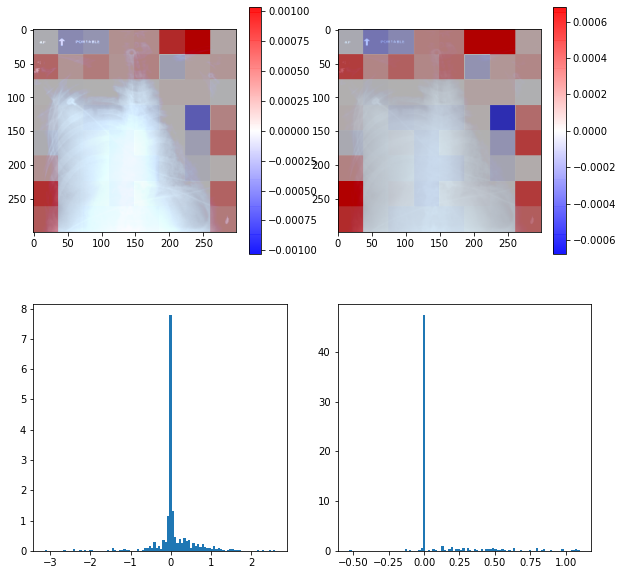

In [9]:
def imshow(ax, pic):
    npimg = np.array(pic)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(2, 2)
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
imshow(ax1, image)
imshow(ax2, image_renorm)
abs = np.abs(hexp_saliency.flatten())
max = np.nanpercentile(abs, 99.9)
im = ax1.imshow(hexp_saliency, cmap='bwr', alpha=0.7, vmax=max, vmin=-max)
plt.colorbar(im, ax=ax1)
abs_renorm = np.abs(hexp_saliency_renorm.flatten())
max_renorm = np.nanpercentile(abs_renorm, 99.9)
im_renorm = ax2.imshow(hexp_saliency, cmap='bwr', alpha=0.7, vmax=max_renorm, vmin=-max_renorm)
plt.colorbar(im_renorm, ax=ax2)
ax3.hist(hexp.phis, 100, density=True)
ax4.hist(hexp_renorm.phis, 100, density=True)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import HShap as HShap
from PIL import Image
import shap

HOME = "."

model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net_path = os.path.join(HOME, "RSNA_InceptionV3.pth")
model.load_state_dict(torch.load(net_path, map_location=device))
model.eval()

preprocess = transforms.Compose(
    [
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.6, 0.448, 0.450]),
    ]
)

DATA_DIR = os.path.join(HOME, "RSNA_example_images")
example_set = datasets.ImageFolder(DATA_DIR, preprocess)
example_names = example_set.imgs
batch_size = 4
example_loader = torch.utils.data.DataLoader(
    example_set, batch_size=batch_size, shuffle=False, num_workers=0
)
example_iter = iter(example_loader)

avg_all_train = np.load('avg_all_train.npy')
background = torch.from_numpy(avg_all_train)

hexp = HShap.Explainer(model, background, M=4)
data = next(example_iter)
images, _ = data
image = images[0]

hexp_saliency, _ = hexp.explain(image, label=1, threshold=0, minW=20, minH=20)

cpu
Initialized explainer with map size (299, 299)
Root input [0, 299] [0 299] with score 1.0000
Root input [0, 149] [0 149] with score 0.1261
Root input [0, 74] [0 74] with score 0.1300
Root input [0, 37] [37 74] with score 0.0486
Root input [37, 74] [0 37] with score 0.0416
Root input [0, 74] [74 149] with score 0.0098
Root input [37, 74] [112 149] with score 0.0213
Root input [74, 149] [0 74] with score 0.0579
Root input [74, 112] [37 74] with score 0.0187
Root input [112, 149] [0 37] with score 0.0249
Root input [112, 149] [37 74] with score 0.0135
Root input [74, 149] [74 149] with score 0.1543
Root input [74, 112] [74 112] with score 0.0246
Root input [74, 112] [112 149] with score 0.0409
Root input [112, 149] [74 112] with score 0.0487
Root input [112, 149] [112 149] with score 0.0016
Root input [0, 149] [149 299] with score 0.2237
Root input [0, 74] [149 224] with score 0.1444
Root input [0, 37] [186 224] with score 0.0306
Root input [37, 74] [186 224] with score 0.0363
Root in

In [4]:
!pip install shap
import shap

deepexp = shap.DeepExplainer(model, background)
deepexp_saliency = deepexp.shap_values(image.view(-1, 3, 299, 299).detach())

plt.imshow(hexp_saliency[0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 3, 3, 3], but got 3-dimensional input of size [3, 3, 299] instead